## Kod w mniejszym lub większym stopniu wzorowany na kodzie z laboratorium 9,10 na Nauczaniu maszynowym, WMI, UJ, 2019/20, semestr zimowy

Feedforward neural network
trained on MINIST dataset

In [1]:
from lib_linear import *
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import torch.nn.functional as F
from scipy.linalg import null_space

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(255/256, 1, N)    ## red  255,192, 203
vals[:, 1] = np.linspace(192/256, 1, N)
vals[:, 2] = np.linspace(203/256, 1, N)  ## blue 75, 0, 130
Pinks = ListedColormap(vals)


top = cm.get_cmap(Pinks, 256)
bottom = cm.get_cmap('Purples', 256)

newcolors = np.vstack((top(np.linspace(0, 1, 256)),
                       bottom(np.linspace(0, 1, 256))))

newcmp = ListedColormap(newcolors, name='PinkPueple')

## Load data

In [2]:
mean, std = calculate_mean_and_std()
train_data, test_data =  download_normalized_data(mean, std)

batch_size = 1
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Input input

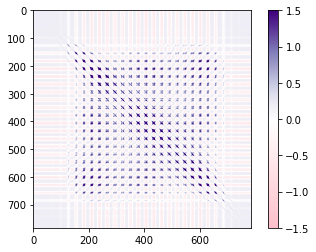

In [3]:
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


P = torch.zeros(784, 784)
counter = 0

for i, (x,y) in enumerate(train_loader):  
        
    P = P + torch.matmul(x.T, x)
    counter += 1
    
P_average = P/counter 
input_input_corr = P_average.detach().numpy()

plt.imshow(P_average, cmap = newcmp, vmax = 1.5, vmin = -1.5)
plt.colorbar()
plt.show()
     

# output-input

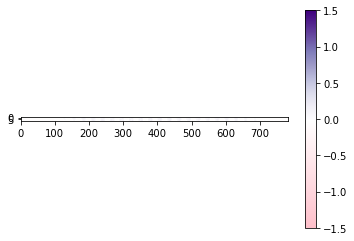

In [4]:
P = torch.zeros(10, 784)
counter = 0

for i, (x,y) in enumerate(train_loader):  
        
    Y = torch.zeros(10)
    Y[y[0]]=1    
    P = P + (torch.mm(Y.view(10, 1), x.view(1, 784)))
    counter += 1
   
    
P_average = P/counter
output_input_corr = P_average.detach().numpy()

plt.imshow(P_average, cmap = newcmp, vmax = 1.5, vmin = -1.5)
plt.colorbar()
plt.show() 

## Output- output

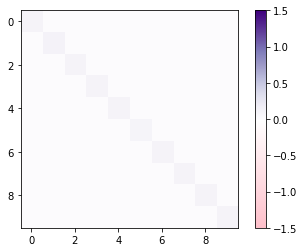

In [5]:
P = torch.zeros(10, 10)
counter = 0

for i, (x,y) in enumerate(train_loader):  
        
    Y = torch.zeros(10)
    Y[y[0]]=1
    P = P + (torch.mm(Y.view(10, 1), Y.view(1,10)))
    counter += 1
    
P_average = P/counter 
output_output_corr = P_average.detach().numpy()

plt.imshow(output_output_corr, cmap = newcmp, vmax = 1.5, vmin = -1.5)
plt.colorbar()
plt.show() 

## Singular value decomposition of $\Sigma^{31}$ (input-output corr)

In [6]:
u, s, vh = np.linalg.svd(output_input_corr, full_matrices=True, compute_uv=True, hermitian=False)

## Show, that $V^{11}$ from the paper does not work

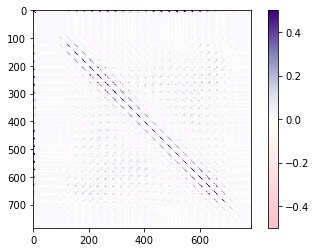

In [7]:
Sigma = vh.T @ input_input_corr @ vh   ## Sigma -> S11

plt.imshow(Sigma, cmap = newcmp, vmax = .5, vmin = -0.5)
plt.colorbar()
plt.show()

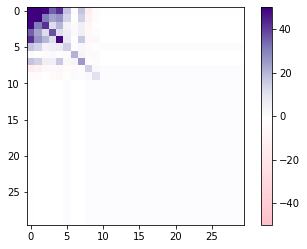

In [8]:
Sigma = vh.T @ input_input_corr @ vh   ## Sigma -> S11
plt.imshow(Sigma[:30,:30], cmap = newcmp, vmax = 50, vmin = -50)
plt.colorbar()
plt.show()

## Create $V^{11}$ such that $S^{31} = U^{33} \Sigma ^{31} V^{11T} $ and $S^{11} = V^{11} \Sigma^{11} V^{11T}$

In [9]:
v_importantT = np.zeros((784, 784))
v_importantT[:10, :] = vh[:10, :]

v_important = v_importantT.T

P_Vimp = (np.identity(784) - (v_important @ v_importantT))

in_in_corr_otro = P_Vimp @ input_input_corr @ P_Vimp
eig_orto, v_orto =  np.linalg.eig(in_in_corr_otro)

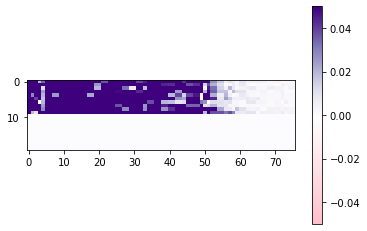

In [10]:
M = np.abs(v_importantT@v_orto)
plt.imshow(M[:20,708:], cmap = newcmp, vmax = .05, vmin = -0.05)
plt.colorbar()
plt.show()

In [11]:
v_new = np.zeros((784, 784))
v_new[:, :10] = v_important[:,:10]
v_new[:, 10:718] = v_orto[:, :708]

<ipython-input-11-6499d95569c4>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  v_new[:, 10:718] = v_orto[:, :708]


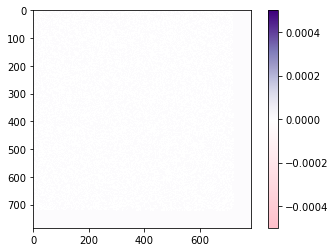

In [12]:
temp = np.zeros((784, 784))
temp[:718,:718] = np.identity(718)

plt.imshow(v_new.T @ v_new - temp, cmap = newcmp, vmax = .0005, vmin = -0.0005)
plt.colorbar()
plt.show()

### Gram-Schmidt procedure to complet V:

In [13]:
from copy import copy
v_my = copy(v_new)

for i in range(718, 784):
    x = np.random.uniform( size=(784)) 
    x /= np.linalg.norm(x)
    for j in range(i):
        col = v_my[:, j]
        x -= x.dot(col) * col/ np.linalg.norm(col)**2
    
    v_my[:,i] = x/ np.linalg.norm(x)
    

## Final check

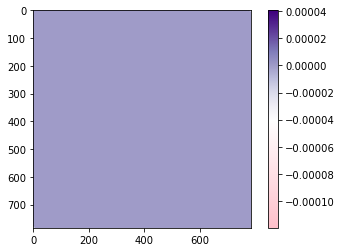

In [14]:
VVV = v_my.T @ v_my

plt.imshow(v_my.T @ v_my - np.identity(784), cmap = newcmp)
plt.colorbar()
plt.show()

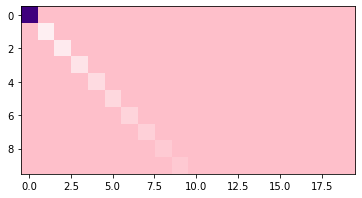

In [15]:
ss = np.zeros((10, 784))
ss[:10, :10] = np.diag(s)
plt.imshow(ss[:10, :20], cmap=newcmp)

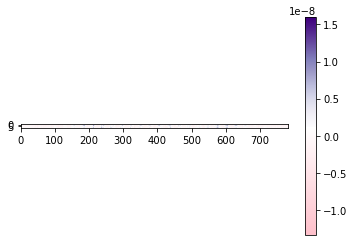

In [16]:
s31_check = (u @ ss @ v_my.T)

plt.imshow(output_input_corr - s31_check, cmap = newcmp)
plt.colorbar()
plt.show()

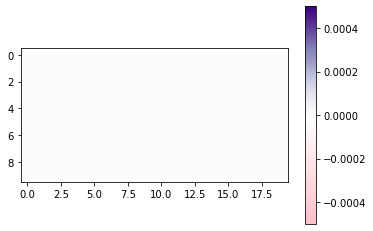

In [17]:
error = vh-v_my.T
plt.imshow(error[:10,:20], cmap = newcmp, vmax = .0005, vmin = -0.0005)
plt.colorbar()
plt.show()

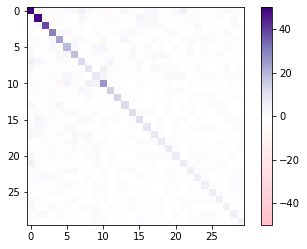

In [18]:
Sigma_new = (v_my.T) @ input_input_corr @ v_my
plt.imshow(Sigma_new[:30,:30], cmap = newcmp, vmax = 50, vmin = -50)
plt.colorbar()
plt.show()

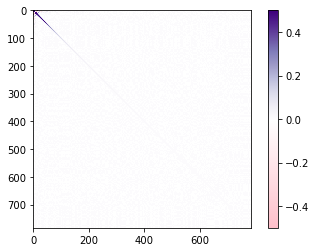

In [19]:
Sigma_new = (v_my.T) @ input_input_corr @ v_my
plt.imshow(Sigma_new[:,:], cmap = newcmp, vmax = 0.5, vmin = -0.5)
plt.colorbar()
plt.show()

# $L^2$-distance from completly diagonal $S^{11}$

In [20]:
sigma_eig_real, v_real =  np.linalg.eig(input_input_corr)

In [21]:
for i in range(20):
    print("{:}: \t Our approx: {:.3f} \t real rigenvalue: {:.3f}".format(i,Sigma_new[i,i], sigma_eig_real[i]))

0: 	 Our approx: 248.423 	 real rigenvalue: 249.106+0.000j
1: 	 Our approx: 48.738 	 real rigenvalue: 50.688+0.000j
2: 	 Our approx: 38.628 	 real rigenvalue: 39.409+0.000j
3: 	 Our approx: 29.651 	 real rigenvalue: 34.023+0.000j
4: 	 Our approx: 22.886 	 real rigenvalue: 29.268+0.000j
5: 	 Our approx: 19.195 	 real rigenvalue: 23.952+0.000j
6: 	 Our approx: 18.187 	 real rigenvalue: 20.233+0.000j
7: 	 Our approx: 12.204 	 real rigenvalue: 16.149+0.000j
8: 	 Our approx: 8.765 	 real rigenvalue: 15.823+0.000j
9: 	 Our approx: 8.389 	 real rigenvalue: 13.169+0.000j
10: 	 Our approx: 25.659 	 real rigenvalue: 11.747+0.000j
11: 	 Our approx: 14.974 	 real rigenvalue: 11.465+0.000j
12: 	 Our approx: 13.867 	 real rigenvalue: 10.384+0.000j
13: 	 Our approx: 12.466 	 real rigenvalue: 9.505+0.000j
14: 	 Our approx: 11.247 	 real rigenvalue: 9.192+0.000j
15: 	 Our approx: 10.523 	 real rigenvalue: 8.298+0.000j
16: 	 Our approx: 8.321 	 real rigenvalue: 7.852+0.000j
17: 	 Our approx: 8.150 	 rea

So to order properly one has to pemutate rows and colums in sugma_new, or equivelently in sigme_real.

The order of the eigenvalues in sigma_new should be:

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15... (original order)

0,1,2,3,10,4,5,6,11,12,13,7,14,15,8,9,... (unchanged order)

So I has to reverse ths swiching in sigma_real

In [22]:
from copy import copy, deepcopy

In [23]:
sigma_eig_prem1 =  deepcopy(sigma_eig_real)
sigma_eig_prem2 =  deepcopy(sigma_eig_real)


sigma_eig_prem1[0] = sigma_eig_real[0]
sigma_eig_prem1[1] = sigma_eig_real[1]
sigma_eig_prem1[2] = sigma_eig_real[2]
sigma_eig_prem1[3] = sigma_eig_real[3]
sigma_eig_prem1[4] = sigma_eig_real[10]
sigma_eig_prem1[5] = sigma_eig_real[4]
sigma_eig_prem1[6] = sigma_eig_real[5]
sigma_eig_prem1[7] = sigma_eig_real[6]
sigma_eig_prem1[8] = sigma_eig_real[11]
sigma_eig_prem1[9] = sigma_eig_real[12]

sigma_eig_prem1[10] = sigma_eig_real[13]
sigma_eig_prem1[11] = sigma_eig_real[7]
sigma_eig_prem1[12] = sigma_eig_real[14]
sigma_eig_prem1[13] = sigma_eig_real[15]
sigma_eig_prem1[14] = sigma_eig_real[8]
sigma_eig_prem1[15] = sigma_eig_real[9]

sigma_eig_prem2[0] = sigma_eig_real[0]
sigma_eig_prem2[1] = sigma_eig_real[1]
sigma_eig_prem2[2] = sigma_eig_real[2]
sigma_eig_prem2[3] = sigma_eig_real[3]
sigma_eig_prem2[4] = sigma_eig_real[5]
sigma_eig_prem2[5] = sigma_eig_real[6]
sigma_eig_prem2[6] = sigma_eig_real[7]
sigma_eig_prem2[7] = sigma_eig_real[11]
sigma_eig_prem2[8] = sigma_eig_real[14]
sigma_eig_prem2[9] = sigma_eig_real[15]

sigma_eig_prem2[10] = sigma_eig_real[4]
sigma_eig_prem2[11] = sigma_eig_real[8]
sigma_eig_prem2[12] = sigma_eig_real[9]
sigma_eig_prem2[13] = sigma_eig_real[10]
sigma_eig_prem2[14] = sigma_eig_real[12]
sigma_eig_prem2[15] = sigma_eig_real[13]

for i in range(20):
    print(" \t Our approx: {:.3f} \t real rigenvalue p1: {:.3f} \t real rigenvalue p2: {:.3f}".format(Sigma_new[i,i], sigma_eig_prem1[i],sigma_eig_prem2[i]))

 	 Our approx: 248.423 	 real rigenvalue p1: 249.106+0.000j 	 real rigenvalue p2: 249.106+0.000j
 	 Our approx: 48.738 	 real rigenvalue p1: 50.688+0.000j 	 real rigenvalue p2: 50.688+0.000j
 	 Our approx: 38.628 	 real rigenvalue p1: 39.409+0.000j 	 real rigenvalue p2: 39.409+0.000j
 	 Our approx: 29.651 	 real rigenvalue p1: 34.023+0.000j 	 real rigenvalue p2: 34.023+0.000j
 	 Our approx: 22.886 	 real rigenvalue p1: 11.747+0.000j 	 real rigenvalue p2: 23.952+0.000j
 	 Our approx: 19.195 	 real rigenvalue p1: 29.268+0.000j 	 real rigenvalue p2: 20.233+0.000j
 	 Our approx: 18.187 	 real rigenvalue p1: 23.952+0.000j 	 real rigenvalue p2: 16.149+0.000j
 	 Our approx: 12.204 	 real rigenvalue p1: 20.233+0.000j 	 real rigenvalue p2: 11.465+0.000j
 	 Our approx: 8.765 	 real rigenvalue p1: 11.465+0.000j 	 real rigenvalue p2: 9.192+0.000j
 	 Our approx: 8.389 	 real rigenvalue p1: 10.384+0.000j 	 real rigenvalue p2: 8.298+0.000j
 	 Our approx: 25.659 	 real rigenvalue p1: 9.505+0.000j 	 re

In [31]:
sigma_real_p1 = np.diag(np.real(sigma_eig_prem1))
sigma_real_p2 = np.diag(np.real(sigma_eig_prem2))

diff_p1 = sigma_real_p1 - Sigma_new
diff_p2 = sigma_real_p2 - Sigma_new

delta_p1 = np.sqrt(np.trace(diff_p1 @ diff_p1.T))
delta_p2 = np.sqrt(np.trace(diff_p2 @ diff_p1.T))

norm_real_p1 = np.sqrt(np.trace(sigma_real_p1 @ sigma_real_p1.T))
norm_real_p2 = np.sqrt(np.trace(sigma_real_p2 @ sigma_real_p2.T))

norm_our = np.sqrt(np.trace(Sigma_new @ Sigma_new.T))

print("norm_our = {:.3f}\t norm_real_1 = {:.3f} \t norm_real_2 = {:.3f}   \n delta_1 = {:.3f} \t delta_2 = {:.3f}".format(norm_our,norm_real_p1,norm_real_p2,delta_p1,delta_p2 ))

norm_our = 266.755	 norm_real_1 = 266.755 	 norm_real_2 = 266.755   
 delta_1 = 40.397 	 delta_2 = 29.868


In [32]:
print("percentage of error: {:.4f}".format(delta_p2/norm_our))

percentage of error: 0.1120


## Nondiagonal error

In [34]:
Sigma_new_offdiag = deepcopy(Sigma_new)

for i in range(len(sigma_eig_real)):
    Sigma_new_offdiag[i,i] = 0
    
offdiag_delta = np.sqrt(np.trace(Sigma_new_offdiag.T @ Sigma_new_offdiag))

print("Off diag delta: {:.4f}".format(offdiag_delta))
print("Percentage offdig error: {:.4f}".format(offdiag_delta/norm_our))

Off diag delta: 30.6574
Percentage offdig error: 0.1149


In [27]:
STOP

NameError: name 'STOP' is not defined

## Save important stuff

In [ ]:
import pandas as pd

V_matrix = pd.DataFrame(v_my) ## V11
U_matrix = pd.DataFrame(u)    ## U33
S_matrix = pd.DataFrame(s)    ## S31

input_input_matrix = pd.DataFrame(input_input_corr) 
output_input_matrix = pd.DataFrame(output_input_corr) 
output_output_matrix = pd.DataFrame(output_output_corr) 


V_matrix.to_csv('V_matrix.csv', index=False)
U_matrix.to_csv('U_matrix.csv', index=False)
S_matrix.to_csv('S_matrix.csv', index=False)

input_input_matrix.to_csv('input_input_matrix.csv', index=False)
output_input_matrix.to_csv('output_input_matrix.csv', index=False)
output_output_matrix.to_csv('output_output_matrix.csv', index=False)

## ERROR FOR $\Sigma 11$

In [ ]:
input_input_matrix = np.array(pd.read_csv('input_input_matrix.csv'))
output_input_matrix = np.array(pd.read_csv('output_input_matrix.csv'))
output_output_matrix = np.array(pd.read_csv('output_output_matrix.csv'))

V_matrix = np.array(pd.read_csv('V_matrix.csv'))
U_matrix = np.array(pd.read_csv('U_matrix.csv'))
S31_matrix = np.array(pd.read_csv('S_matrix.csv'))  ##actually, just diag values

S11_matrix = V_matrix.T @ input_input_matrix @ V_matrix
S33_matrix = output_output_matrix

In [ ]:
eig_orto, v_orto =  np.linalg.eig(input_input_matrix)
np.real(eig_orto[:20])

In [ ]:
my_arr = [249.10614602,  50.68760441,  39.40858918, 
        29.26792023,  23.9517682 ,  20.23329846,  16.14855943,
        11.747011  ,  9.50536646,   9.19151905]

In [ ]:
np.diag(V_matrix.T @ input_input_matrix @V_matrix)[:10]

In [ ]:
error_arr= np.abs(np.real(my_arr[:10]) - np.diag(Sigma_new)[:10])

In [ ]:
error = 0
for alpha in range(10):
    error+= (S31_matrix[alpha])**2/(S11_matrix[alpha][alpha])**2 *error_arr[alpha]
error   